In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#!pip install pmdarima
#import pmdarima as pm
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# function to plot results
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

# function to calc RMSE and R^2; and also plot results
def eval_results(y, yhat, y_scaler = None):
    if y_scaler != None:
        yhat = y_scaler.inverse_transform(np.array(yhat).reshape(-1,1)).flatten()
        
    print("RMSE: ", mean_squared_error(y, yhat, squared = False))
    print("R^2: ", r2_score(y, yhat))
    print("benchmark RMSE: ", mean_squared_error(y, np.zeros(len(y)), squared = False))
    print("benchmark R^2: ", mean_squared_error(y, np.zeros(len(y))))
    
    plt.figure(figsize = (20,10))
    plot_series(np.arange(len(y)), y)
    plot_series(np.arange(len(yhat)), yhat)

In [2]:
df = pd.read_csv(r'electricityPrice.csv')
df

,Date,Price,Load
0,2000-01-01,18.696250,5805.708333
1,2000-01-02,41.727083,5994.125000
2,2000-01-03,34.268333,6405.416667
3,2000-01-04,30.059167,6424.916667
4,2000-01-05,30.274167,6372.083333
...,...,...,...
7300,2019-12-27,31.693333,10304.291667
7301,2019-12-28,34.392500,10193.291667
7302,2019-12-29,37.552083,10078.125000
7303,2019-12-30,34.355833,10350.625000


Text(0.5, 1.0, 'Probplot after Box-Cox transformation')

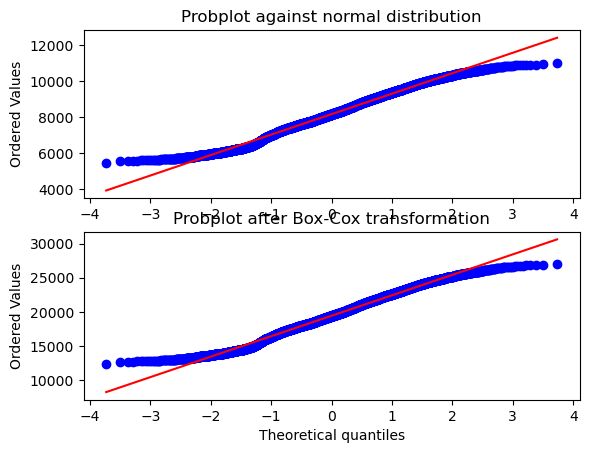

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df["Load"], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, lmbda = stats.boxcox(df["Load"])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
series = pd.Series(data=df['Load'].values, index=df["Date"], dtype="float64", name="Load")

In [14]:
plt.rcParams.update({'figure.figsize':(13,5), 'figure.dpi':120})
split_time = 6940 #2019-01-01

series_train = series[:split_time]
series_valid = series[split_time:]
raw_valid = df['Price'][split_time:]

<AxesSubplot:xlabel='Date'>

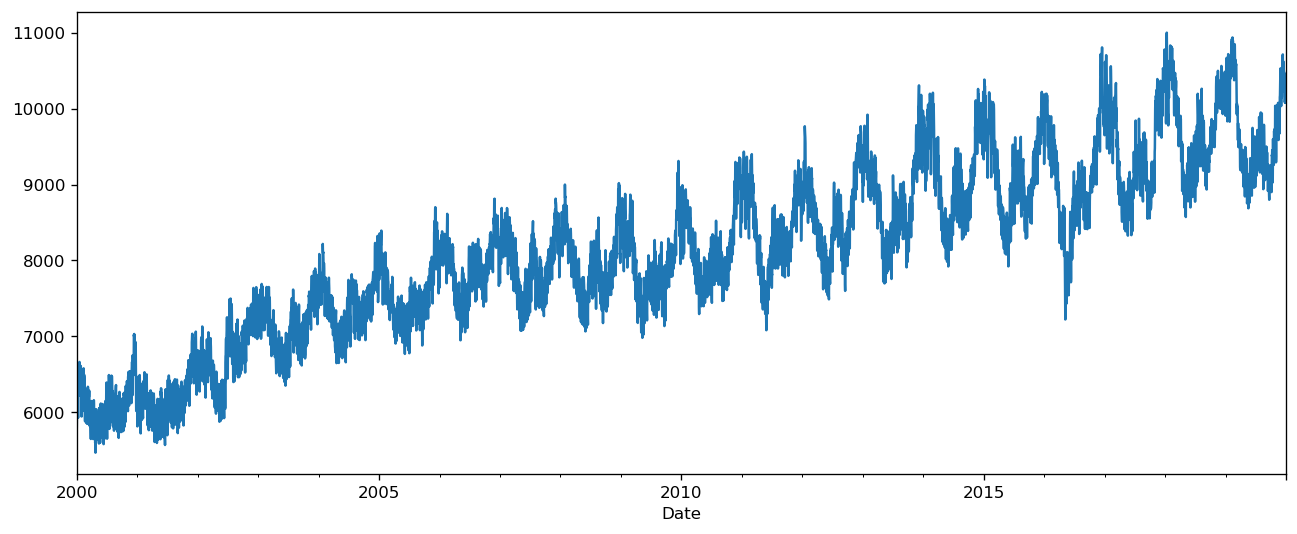

In [16]:
series.dropna().plot()
#df[df["Price"]==0]

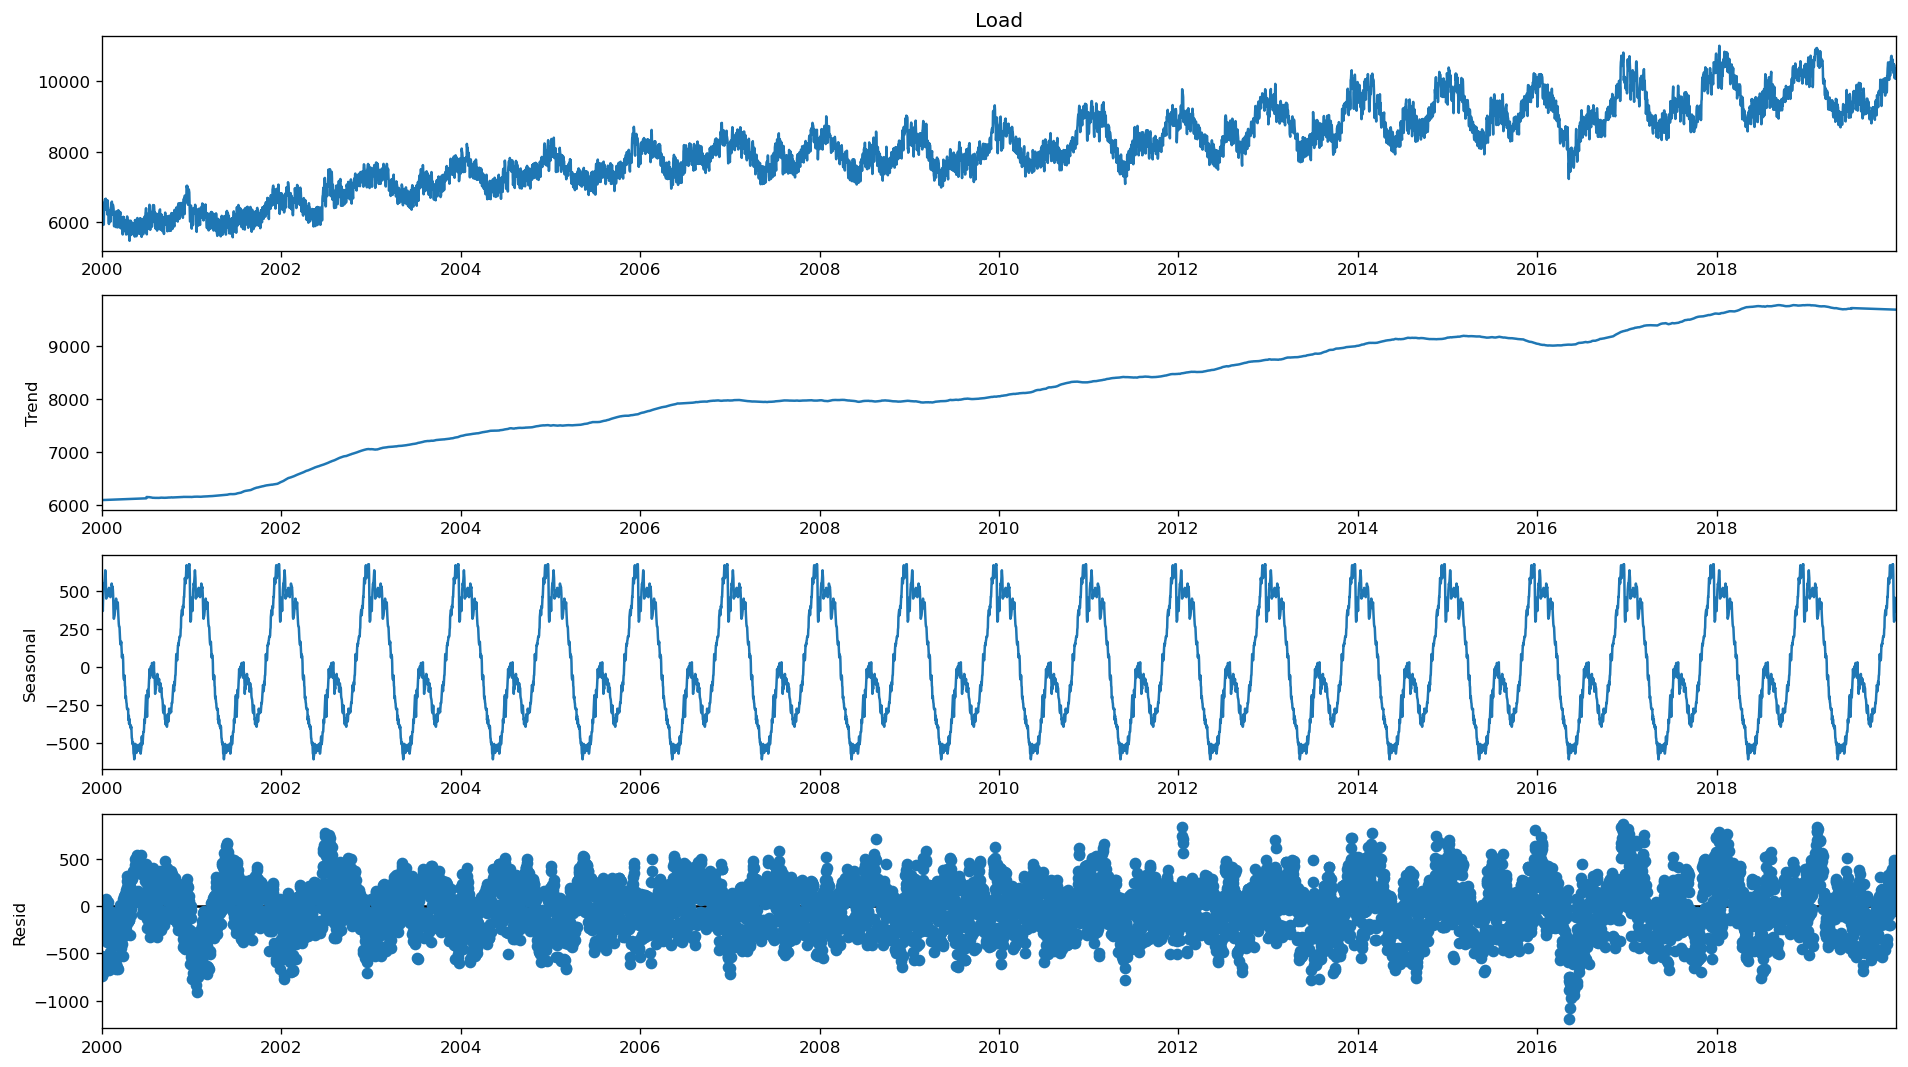

ADF Statistic: -9.536818
p-value: 0.000000


<AxesSubplot:xlabel='Date'>

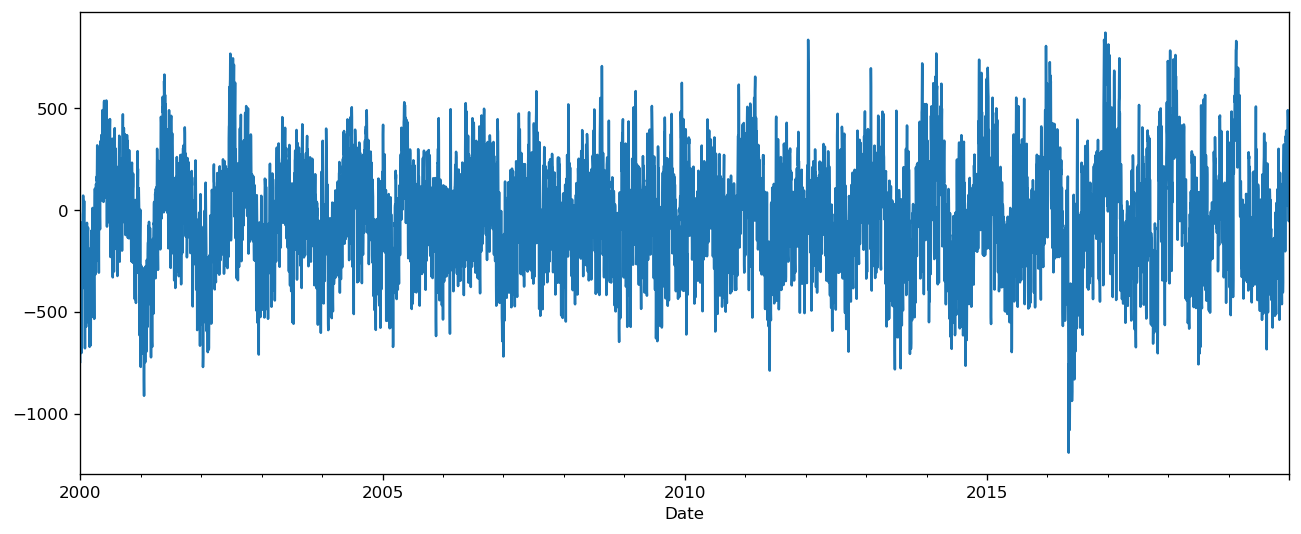

In [19]:
decomposed2 = seasonal_decompose(series, model='additive', period=365, extrapolate_trend='freq')

fig = decomposed2.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

adf_val = adfuller(decomposed2.resid)
print('ADF Statistic: %f' % adf_val[0])
print('p-value: %f' % adf_val[1])
#print(pm.arima.ndiffs(decomposed2.resid, test='kpss'))
decomposed2.resid.plot()

ADF Statistic: -3.028072
p-value: 0.032355


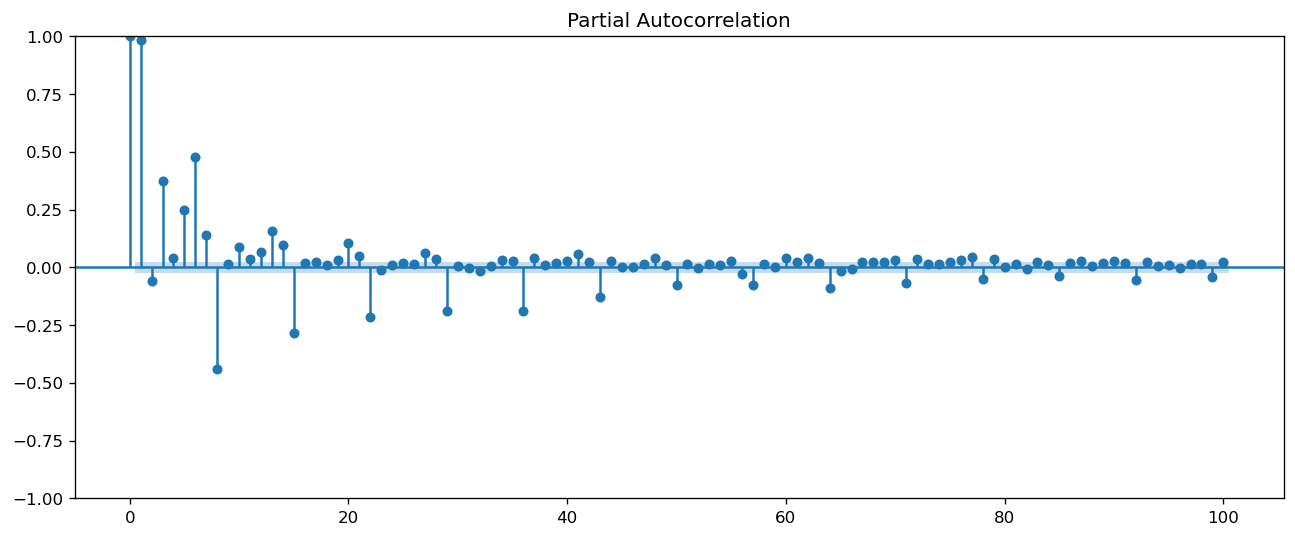

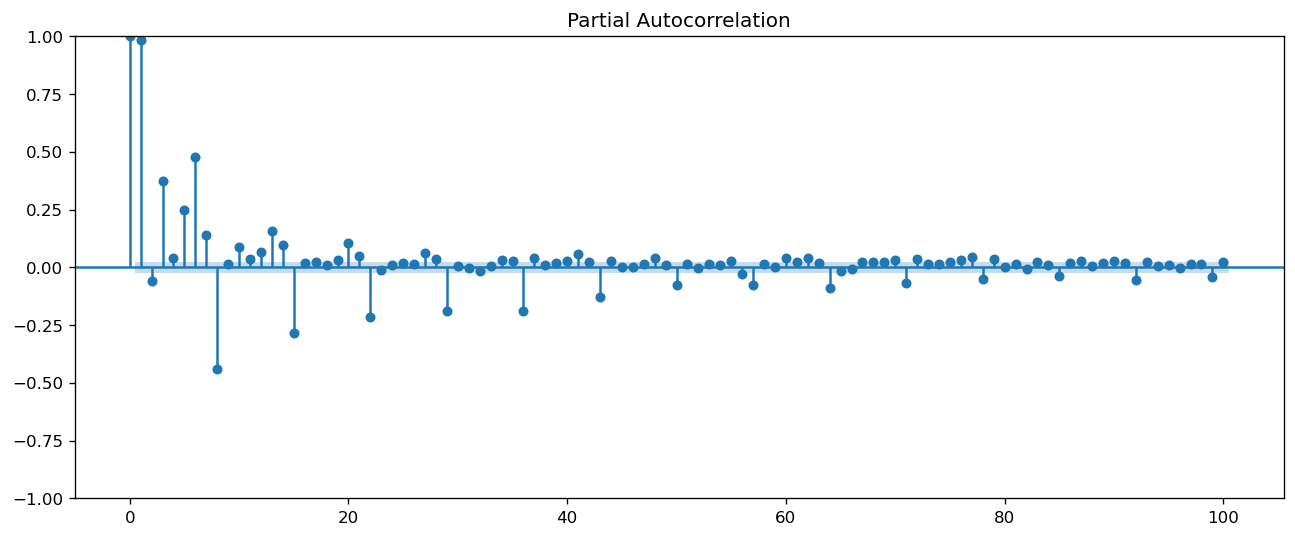

In [22]:
#residual = result.resid.dropna()
#residual

adf_val = adfuller(series)
print('ADF Statistic: %f' % adf_val[0])
print('p-value: %f' % adf_val[1])

plot_pacf(series, lags=100)

#print(pm.arima.ndiffs(series, test='kpss'))


In [ ]:
model = pm.auto_arima(series, start_p=1, start_q=0,
                 # use adftest to find optimal 'd'
                      max_p=8, max_q=1, # maximum p and q
                      m=0,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      start_Q=0,
                      max_P=0,
                      max_Q=0,
                      D=1, 
                      #test='adf',
                      stepwise=True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      with_intercept=False, 
                      out_of_sample_size=len(series)-split_time
                      )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-12231.525, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11932.302, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-12491.065, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13474.634, Time=1.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13449.185, Time=3.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 6.780 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7305
Model:               SARIMAX(1, 1, 1)   Log Likelihood                6740.317
Date:                Sun, 24 Apr 2022   AIC                         -13474.634
Time:                        10:32:33   BIC                         -13453.946
Sample:                             0   HQIC                        -13467.520
                               - 7305                             

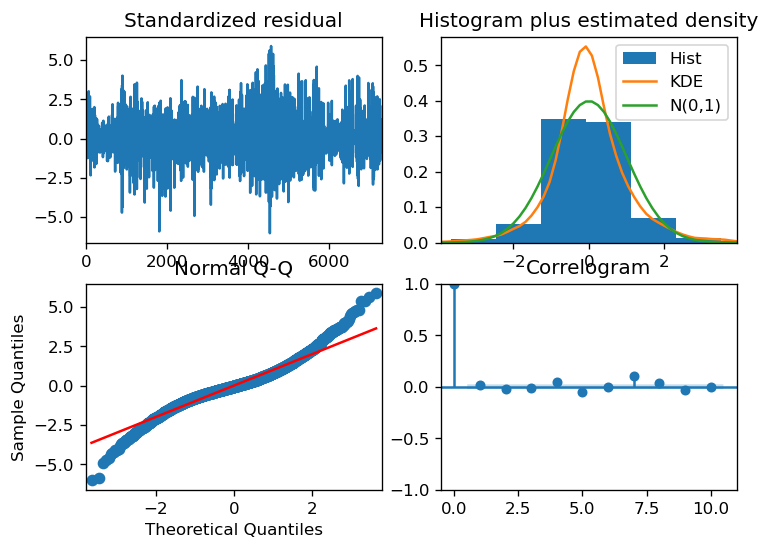

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()


In [ ]:
predictions = model.predict_in_sample(start=split_time, end=len(series)-1, dynamic=False)
result = inv_boxcox(predictions, lmbda)

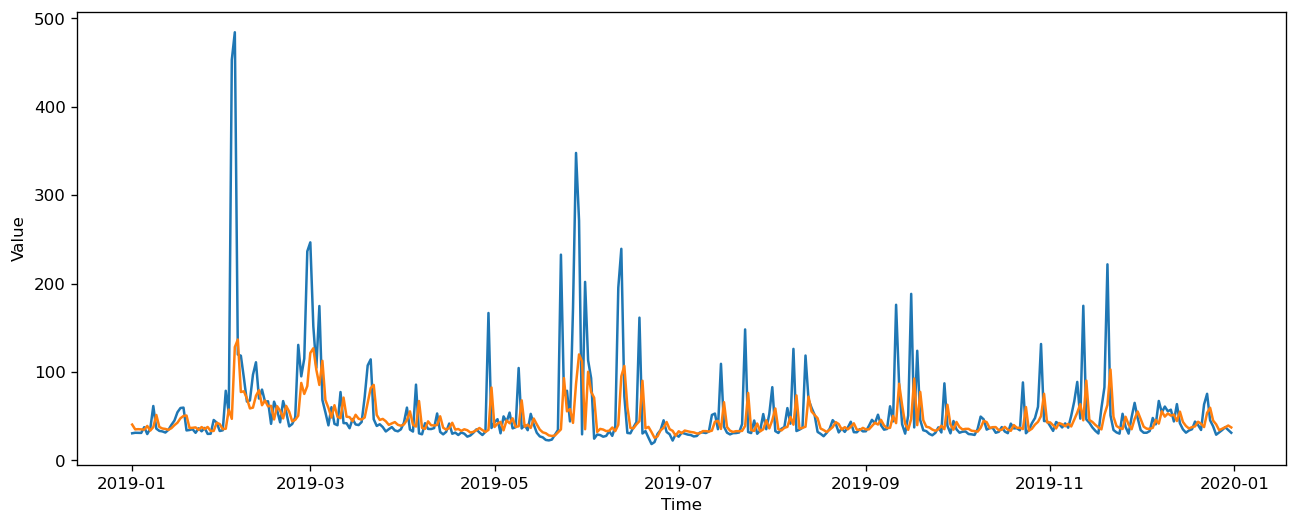

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

plot_series(series_valid.index, raw_valid)
plot_series(series_valid.index, result)

In [ ]:
tf.keras.metrics.mean_absolute_error(raw_valid, result).numpy()

20.517411743359748

In [ ]:
tf.keras.metrics.mean_absolute_error(raw_valid, df['Price'][split_time-1:].shift().dropna()).numpy()

24.35091729402422

In [ ]:
model3 = SARIMAX(series_train, order=(1,1,1)) #,seasonal_order=(1, 1, 0, 7))
model_fit = model3.fit()
print(model_fit.summary())
mod = SARIMAX(series, order=(1,1,1))#, seasonal_order=(1, 1, 0, 7))
res = mod.filter(model_fit.params)

C:\Users\andr_\miniconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andr_\miniconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 6940
Model:               SARIMAX(1, 1, 1)   Log Likelihood                6377.877
Date:                Mon, 25 Apr 2022   AIC                         -12749.753
Time:                        09:24:00   BIC                         -12729.218
Sample:                    01-01-2000   HQIC                        -12742.674
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5590      0.009     65.513      0.000       0.542       0.576
ma.L1         -0.9599      0.003   -276.402      0.000      -0.967      -0.953
sigma2         0.0093      0.000     92.292      0.0

C:\Users\andr_\miniconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andr_\miniconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


20.5208162847348


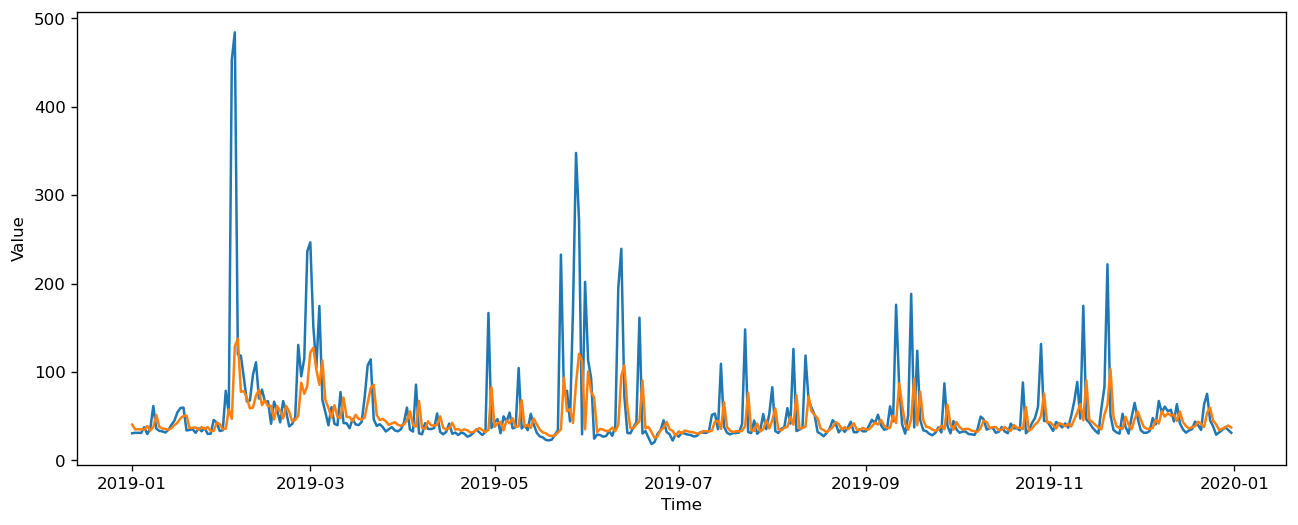

In [ ]:
predict = res.get_prediction(start=split_time, end=len(series)-1, dynamic=False)
predict.predicted_mean
res2 = inv_boxcox(predict.predicted_mean, lmbda)
print(tf.keras.metrics.mean_absolute_error(raw_valid, res2).numpy())
plot_series(series_valid.index, raw_valid)
plot_series(series_valid.index, res2)

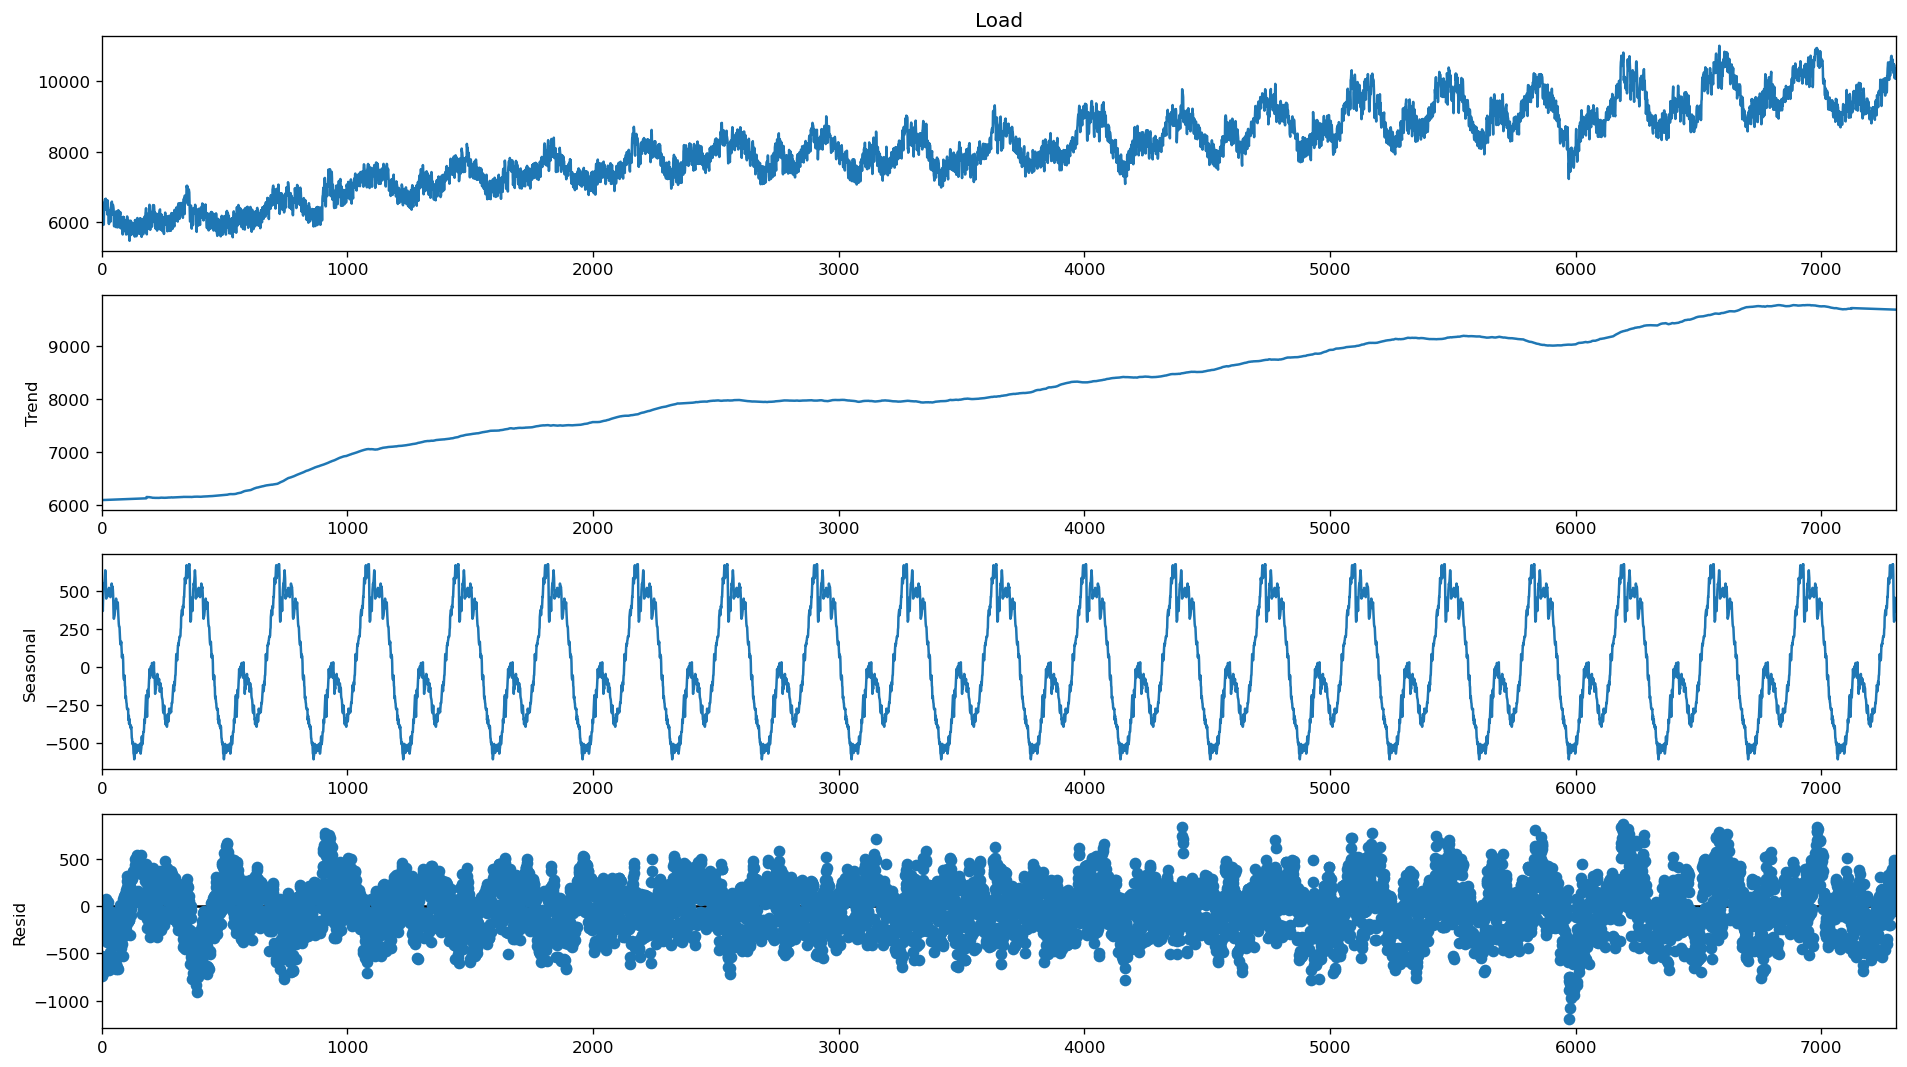

0


In [ ]:
decomposed = seasonal_decompose(df['Load'], model='additive', period=365, extrapolate_trend='freq')

fig = decomposed.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()
print(pm.arima.ndiffs(decomposed.resid, test='kpss'))

In [ ]:
V = decomposed.resid.to_numpy().reshape(-1,1)
#V = df["Load"].to_numpy().reshape(-1,1)

In [ ]:
model1 = pm.auto_arima(series, X=V, start_p=1, start_q=0,
                 # use adftest to find optimal 'd'
                      max_p=1, max_q=1, # maximum p and q
                      m=365,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      start_Q=0,
                      max_P=0,
                      max_Q=0,
                      D=1, 
                      #test='adf',
                      stepwise=True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      with_intercept=False, 
                      out_of_sample_size=len(series)-split_time
                      )

print(model1.summary())

C:\Users\andr_\miniconda3\envs\ml\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-13090.721, Time=2.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12656.397, Time=4.84 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13362.804, Time=1.99 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14096.281, Time=2.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14094.279, Time=3.38 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 15.676 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7305
Model:               SARIMAX(1, 1, 1)   Log Likelihood                7052.141
Date:                Sun, 24 Apr 2022   AIC                         -14096.281
Time:                        00:57:44   BIC                         -14068.696
Sample:                             0   HQIC                        -14086.796
                               - 7305                            

20.17556978322464


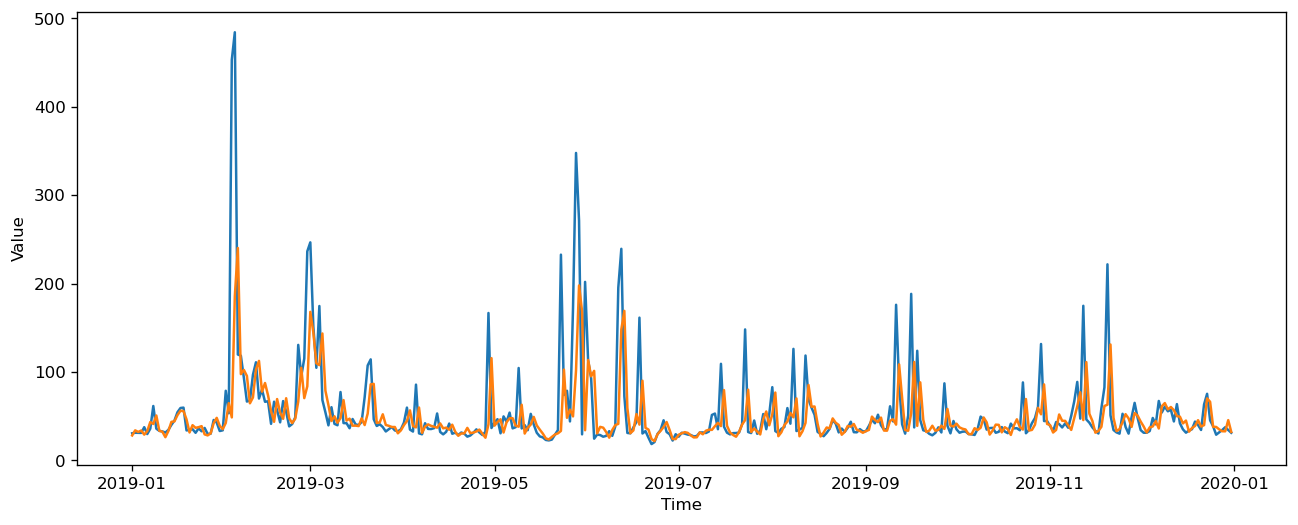

In [ ]:
predictions = model1.predict_in_sample(X= V[split_time:], start=split_time, end=len(series)-1, dynamic=False)
result = inv_boxcox(predictions, lmbda)
print(tf.keras.metrics.mean_absolute_error(raw_valid, result).numpy())
plot_series(series_valid.index, raw_valid)
plot_series(series_valid.index, result)

In [ ]:
residuals= model1.resid()

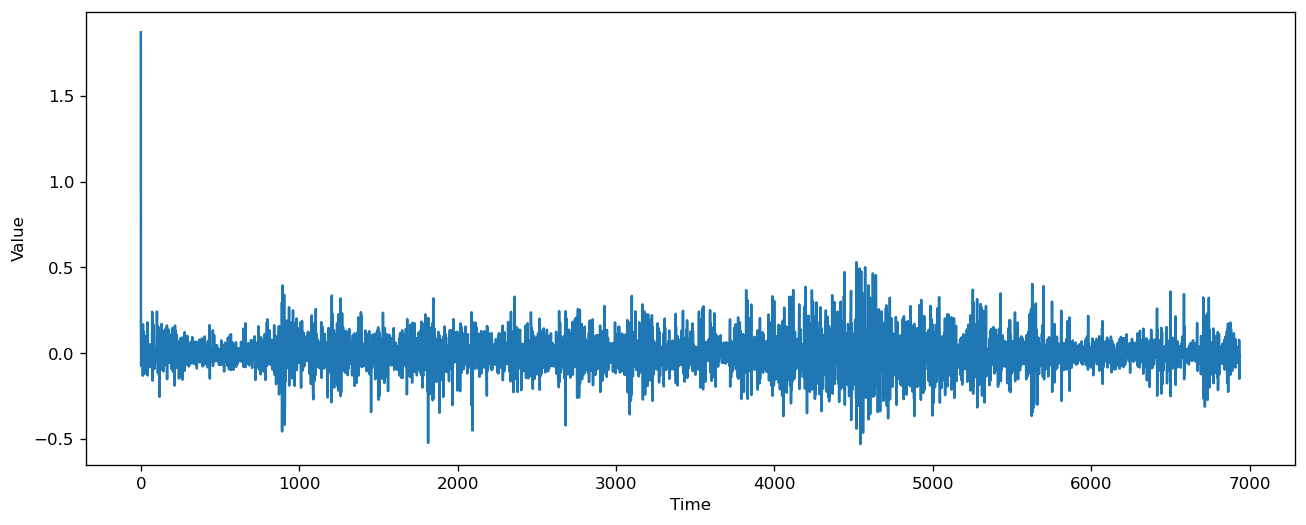

In [ ]:
time = np.arange(np.shape(df)[0], dtype="float32")

plot_series(time[:split_time],residuals[:split_time])